In [102]:
"""
Imported Libraries

re - Regex library
json - Json library
requests - HTTP library
matplotlib.pyplot (plt) - Matplotlib Plotting library
numpy (np) - Mathematics library
"""
import re
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

In [115]:
"""
Global Variables

_token - API token for ipinfo.io
_masscan_output - Masscan Grepable output contents
_targets - Target file contents
"""
with open('token.txt') as f:
    _token = f.read()
with open('targets.txt') as f:
    _masscan_output = f.read()

In [104]:
def extended_ip_info(ip: dict, token: str) -> dict:
    """
    Grabs extended IP information from ipinfo.io
    
    :param ip: IP address to look up
    :type ip: str
    :param token: API Token for ipinfo.io
    :type token: str
    :return: Extend dict
    :type return: dict
    """
    r = requests.get('https://ipinfo.io/{}?token={}'.format(ip, token))
    r.raise_for_status()
    return r.json()    

In [105]:
def parse_hosts(masscan_output: str) -> dict:
    """
    Parses the masscan grepable output format
    
    :param masscan_output: The file contents of the file
    :type masscan_output: str
    :return: Dict containing the parsed out hosts
    :type return: dict
    """
    ip_re = re.compile(r"Host: (?P<ip>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})") # Extracts IP address from the file
    hosts = {}
    for l in masscan_output.split('\n'):
        if not l: # Skip empty lines in the file
            continue
        
        ip = re.search(ip_re, l)['ip']
        if ip not in hosts:
            hosts[ip] = {}
        
        if 'remotemouse.os' in l:
            if 'Windows' in l:
                hosts[ip]['OS'] = 'Windows'
            elif 'MacOs' in l:
                hosts[ip]['OS'] = 'MacOS'

        if 'remotemouse.password_protected' in l:
            if 'TRUE' in l:
                hosts[ip]['password'] = True
            elif 'FALSE' in l:
                hosts[ip]['password'] = False
    
    # Extend the host information
    for host in hosts:
        hosts[host] = {**hosts[host], **extended_ip_info(host, _token)}

    return hosts

In [111]:
_targets = parse_hosts(_masscan_output)
# print(json.dumps(hosts, indent=4, sort_keys=True))

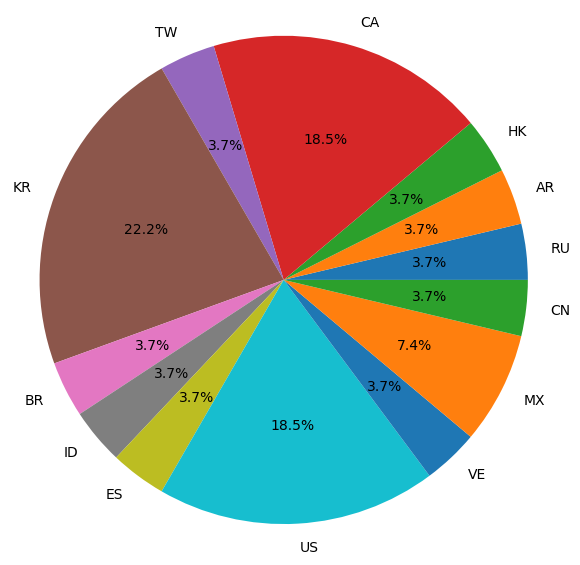

In [107]:
def countries_pieplot(hosts: dict):
    """
    Plots a pie chart by country 
    
    :param hosts: Hosts dict from parse_hosts
    :type hosts: dict
    """
    labels = set(hosts[host]['country'] for host in hosts)
    values = [
        sum(1 if hosts[host]['country'] == country else 0 for host in hosts) for country in labels
    ]
    fig, ax = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(7)
    ax.pie(values, labels=labels, autopct='%1.1f%%')
    ax.axis('equal')
    plt.show()

countries_pieplot(hosts)

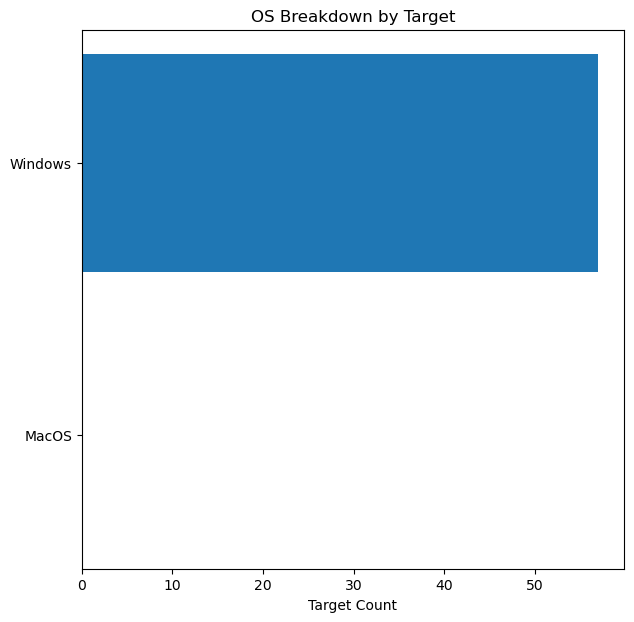

In [108]:
def os_barchart(hosts: dict):
    """
    Plots a bar chart of OS types
    
    :param hosts: Hosts dict from parse_hosts
    :type hosts: dict
    """
    labels = ['Windows', 'MacOS']
    values = [
        len([host for host in hosts if hosts[host]['OS'] == 'Windows']),
        len([host for host in hosts if hosts[host]['OS'] == 'MacOS']),
    ]
    plt.rcdefaults()
    fig, ax = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(7)
    
    ax.barh(labels, values, align='center')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Target Count')
    ax.set_title('OS Breakdown by Target')

    plt.show()

os_barchart(_targets)

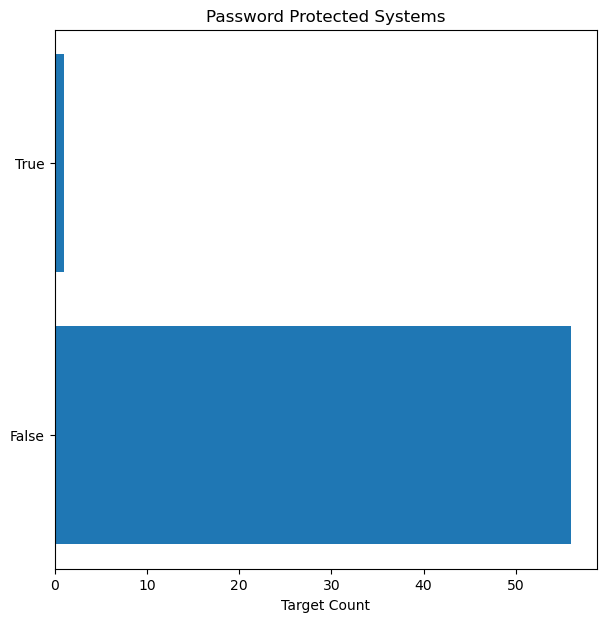

In [109]:
def password_barchart(hosts: dict):
    """
    Plots a bar chart of Password-protected servers
    
    :param hosts: Hosts dict from parse_hosts
    :type hosts: dict
    """
    labels = [True, False]
    values = [
        len([host for host in hosts if not hosts[host]['password']]),
        len([host for host in hosts if hosts[host]['password']]),
    ]
    
    plt.rcdefaults()
    fig, ax = plt.subplots()
    fig.set_figheight(7)
    fig.set_figwidth(7)
    
    ax.barh(labels, values, align='center')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Target Count')
    ax.set_title('Password Protected Systems')

    plt.show()

password_barchart(_targets)

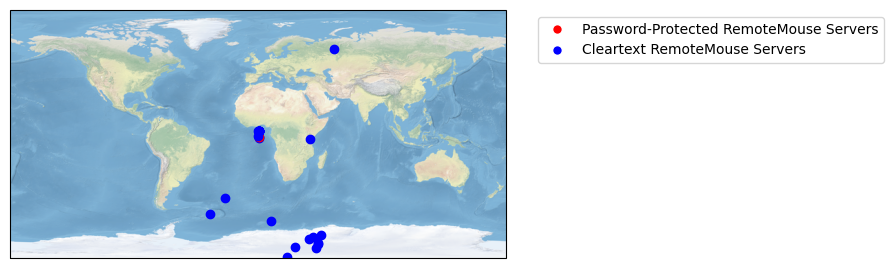

In [110]:
def target_map(hosts: dict):
    """
    Plots a map of targets
    
    :param hosts: Hosts dict from parse_hosts
    :type hosts: dict
    """
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()
    
    for host in hosts:
        coords = [float(i) for i in hosts[host]['loc'].split(',')]
        color = 'red' if hosts[host]['password'] else 'blue'
        plt.plot(*coords, color=color, linewidth=2, marker='o', transform=ccrs.PlateCarree())
    
    plt.legend(handles=[
        matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Password-Protected RemoteMouse Servers', markerfacecolor='r', markersize=7),
        matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Cleartext RemoteMouse Servers', markerfacecolor='b', markersize=7),
    ], bbox_to_anchor=(1.05, 1), loc='upper left')
        

    plt.show()

target_map(hosts)